<a href="https://colab.research.google.com/github/MDfarazuddin99/Masked_Face_Recognition/blob/master/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First of all, You will need to install a face detector library. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mtcnn

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image
import os
from google.colab.patches import cv2_imshow
import dlib


Using TensorFlow backend.


# **Take Test picture**

In [0]:
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    img = Image.open(filename)
    # convert to RGB, if needed
    img = img.convert('RGB')
    # convert to array
    pixels = np.asarray(img)
    #create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    print(results[0]['box'])
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:int(0.775*y2), x1:x2]
    # resize pixels to the model size
    img = Image.fromarray(face)
    img = img.resize(required_size)
    face_array = np.asarray(img)
    plt.imshow(face_array)
    plt.show()
    return face_array

[259, 202, 216, 242]


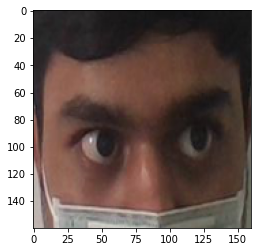

In [21]:
filename= "/content/drive/My Drive/Face_Mask_Data/Masked/Farazuddin/6.jpg"
a = extract_face(filename)